<a href="https://colab.research.google.com/github/JoonYoung-Sohn/practice/blob/master/201208_QA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re
import matplotlib.pyplot as plt

In [2]:
path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/'
                'babi_tasks_1-20_v1-2.tar.gz')

11747328/11745123 [==============================] - 1s 0us/step


In [3]:
with tarfile.open(path) as tar:
 tar.extractall()
 tar.close()

DATA_DIR = 'tasks_1-20_v1-2/en-10k'
TRAIN_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_train.txt")
TEST_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_test.txt")

In [4]:
i = 0
lines = open(TRAIN_FILE , "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    # lno, text = line.split(" ", 1) # ID와 TEXT 분리
    i = i + 1
    print(line)
    if i == 20:
      break

1 Mary moved to the bathroom.
2 John went to the hallway.
3 Where is Mary? 	bathroom	1
4 Daniel went back to the hallway.
5 Sandra moved to the garden.
6 Where is Daniel? 	hallway	4
7 John moved to the office.
8 Sandra journeyed to the bathroom.
9 Where is Daniel? 	hallway	4
10 Mary moved to the hallway.
11 Daniel travelled to the office.
12 Where is Daniel? 	office	11
13 John went back to the garden.
14 John moved to the bedroom.
15 Where is Sandra? 	bathroom	8
1 Sandra travelled to the office.
2 Sandra went to the bathroom.
3 Where is Sandra? 	bathroom	2
4 Mary went to the bedroom.
5 Daniel moved to the hallway.


In [5]:
def read_data(dir):
    stories, questions, answers = [], [], [] 
    story_temp = [] 
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") 
        line = line.strip() 
        idx, text = line.split(" ", 1) 

        if int(idx) == 1:
            story_temp = []

        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") 
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [6]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [7]:
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [8]:
print('훈련용 스토리의 개수 :', len(train_stories))
print('훈련용 질문의 개수 :',len(train_questions))
print('훈련용 답변의 개수 :',len(train_answers))
print('테스트용 스토리의 개수 :',len(test_stories))
print('테스트용 질문의 개수 :',len(test_questions))
print('테스트용 답변의 개수 :',len(test_answers))

훈련용 스토리의 개수 : 10000
훈련용 질문의 개수 : 10000
훈련용 답변의 개수 : 10000
테스트용 스토리의 개수 : 1000
테스트용 질문의 개수 : 1000
테스트용 답변의 개수 : 1000


In [9]:
train_stories[3576]

['John went back to the garden.',
 'Mary went to the kitchen.',
 'Sandra went back to the bedroom.',
 'John travelled to the bedroom.']

In [10]:
train_questions[3576]

'Where is John? '

In [11]:
train_answers[3576]

'bedroom'

In [12]:
def tokenize(sent):
    return [ x.strip() for x in re.split('(\W+)?', sent) if x.strip()]

In [13]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()

    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    story_len = []
    question_len = []

    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [14]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [15]:
print(word2idx)

{'to': 1, 'the': 2, '.': 3, 'went': 4, 'Sandra': 5, 'John': 6, 'Daniel': 7, 'Mary': 8, 'travelled': 9, 'journeyed': 10, 'back': 11, 'bathroom': 12, 'garden': 13, 'hallway': 14, 'moved': 15, 'office': 16, 'kitchen': 17, 'bedroom': 18, 'Where': 19, 'is': 20, '?': 21}


In [16]:
vocab_size = len(word2idx) + 1

In [17]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 68
질문의 최대 길이 : 4


In [18]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [19]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [20]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 68) (10000, 4) (10000, 22) (1000, 68) (1000, 4) (1000, 22)


In [21]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation

In [22]:
train_epochs = 120
batch_size = 32
embed_size = 50
lstm_size = 64
dropout_rate = 0.30

In [23]:
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))

print('Stories :', input_sequence)
print('Question:', question)

Stories : Tensor("input_1:0", shape=(None, 68), dtype=float32)
Question: Tensor("input_2:0", shape=(None, 4), dtype=float32)


In [24]:
# 스토리를 위한 첫번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embedding_dim) 

# 스토리를 위한 두번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) 

In [25]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embedding_dim) 

In [26]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m)
print('Input encoded c', input_encoded_c)
print('Question encoded', question_encoded)

Input encoded m Tensor("sequential/dropout/cond/Identity:0", shape=(None, 68, 50), dtype=float32)
Input encoded c Tensor("sequential_1/dropout_1/cond/Identity:0", shape=(None, 68, 4), dtype=float32)
Question encoded Tensor("sequential_2/dropout_2/cond/Identity:0", shape=(None, 4, 50), dtype=float32)


In [27]:
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_maxlen, question_max_len)

# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_max_len, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_max_len)
print('Response shape', response)

# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)

answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
answer = Activation('softmax')(answer)

Match shape Tensor("activation/truediv:0", shape=(None, 68, 4), dtype=float32)
Response shape Tensor("permute/transpose:0", shape=(None, 4, 68), dtype=float32)
Answer shape Tensor("concatenate/concat:0", shape=(None, 4, 118), dtype=float32)


In [28]:
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])

print(model.summary())

history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))

model.save('model.h5')

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 68)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, 50)     1100        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4, 50)        1100        input_2[0][0]                    
_______________________________________________________________________________________

In [29]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 2ms/step - loss: 0.1247 - acc: 0.9680

 테스트 정확도: 0.9680


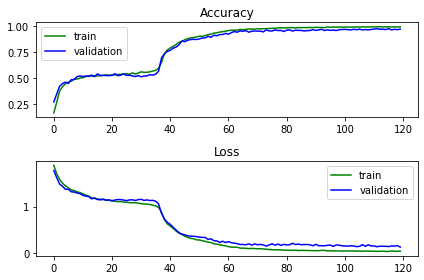

In [30]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

ytest = np.argmax(Ytest, axis=1)
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)